In [12]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Input, Dense,SpatialDropout1D
from keras.layers import LSTM, Embedding
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [5]:
#df=pd.read_csv('https://raw.githubusercontent.com/kushalchauhan98/bcn-cnn-text-classification/master/hm_train.csv')
#df.to_csv('hm_train.csv')
df=pd.read_csv('hm_train.csv')

In [6]:
filter=df['cleaned_hm'].str.len()<=100
df=df[filter]

In [7]:
#rint(df)
LABELS=df['predicted_category'].unique()
y=df['predicted_category']

y = pd.get_dummies(df['predicted_category']).values
print('Shape of label tensor:', y.shape)

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_hm'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['cleaned_hm'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)



Shape of label tensor: (43354, 7)
Shape of data tensor: (43354, 250)


In [17]:


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(LABELS), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 35116 samples, validate on 3902 samples
Epoch 1/5
35116/35116 [==============================] - 245s 7ms/step - loss: 0.7582 - accuracy: 0.7307 - val_loss: 0.3683 - val_accuracy: 0.8795
Epoch 2/5
35116/35116 [==============================] - 267s 8ms/step - loss: 0.2626 - accuracy: 0.9103 - val_loss: 0.2448 - val_accuracy: 0.9157
Epoch 3/5
35116/35116 [==============================] - 283s 8ms/step - loss: 0.1546 - accuracy: 0.9475 - val_loss: 0.2215 - val_accuracy: 0.9190
Epoch 4/5
35116/35116 [==============================] - 272s 8ms/step - loss: 0.1033 - accuracy: 0.9638 - val_loss: 0.2287 - val_accuracy: 0.9231
Epoch 5/5
22336/35116 [==================>...........] - ETA: 1:35 - loss: 0.0738 - accuracy: 0.9747

In [10]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4336/4336 [==============================] - 12s 3ms/step
Test set
  Loss: 0.252
  Accuracy: 0.914


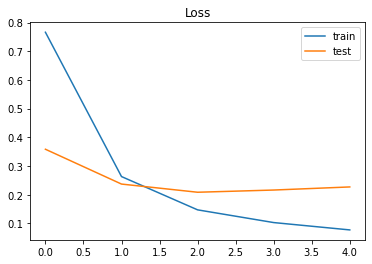

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
predictions=model.predict(X_test)

for key,item in df.iterrows():
    data=item['cleaned_hm']
    seq = tokenizer.texts_to_sequences(new_complaint)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    print(pred, LABELS[np.argmax(pred)])

#index=0
#for key,item in X_test:
#    labels[np.argmax(pred)]
#    print(item,predictions[index])
#    index+=1
